In [2]:
import numpy as np
import torch
import sys
sys.path.append('..')
import swag
import models

import matplotlib.pyplot as plt
%matplotlib inline

## CIFAR 5 Experiment

In the plots below, we will analyze the entropy of both in-class and out-of-class distributions for the various scalable DNN methods.

In [8]:
laplace_inclass = np.load('/home/wesley/Desktop/nfs01_tesla/swa_uncertainties/exps/unc_vgg_cifar10_0620/ent_laplace_0.npz')
laplace_outclass = np.load('/home/wesley/Desktop/nfs01_tesla/swa_uncertainties/exps/unc_vgg_cifar10_0620/ent_laplace_1.npz')

swa_inclass = np.load('/home/wesley/Desktop/nfs01_tesla/swa_uncertainties/exps/unc_vgg_cifar10_0620/ent_swa_0.npz')
swa_outclass = np.load('/home/wesley/Desktop/nfs01_tesla/swa_uncertainties/exps/unc_vgg_cifar10_0620/ent_swa_1.npz')

swag_cov_inclass = np.load('/home/wesley/Desktop/nfs01_tesla/swa_uncertainties/exps/unc_vgg_cifar10_0620/ent_swag_cov_0.npz')
swag_cov_outclass = np.load('/home/wesley/Desktop/nfs01_tesla/swa_uncertainties/exps/unc_vgg_cifar10_0620/ent_swag_cov_1.npz')

swag_nocov_inclass = np.load('/home/wesley/Desktop/nfs01_tesla/swa_uncertainties/exps/unc_vgg_cifar10_0620/ent_swag_nocov_0.npz')
swag_nocov_outclass = np.load('/home/wesley/Desktop/nfs01_tesla/swa_uncertainties/exps/unc_vgg_cifar10_0620/ent_swag_nocov_1.npz')

dropout_inclass = np.load('../exps/fr_uncertainties/ent_dropout_0.pt.npz')
dropout_outclass = np.load('../exps/fr_uncertainties/ent_dropout_1.pt.npz')

I'm also loading the full rank ones.

In [5]:
swagfr_cov_inclass = np.load('../exps/fr_uncertainties/vgg16_0.npz')
swagfr_cov_outclass = np.load('../exps/fr_uncertainties/vgg16_1.pt')

I'm also loading the full rank ones.

In [6]:
swagfr_cov_inclass = np.load('../exps/fr_uncertainties/vgg16_0.npz')
swagfr_cov_outclass = np.load('../exps/fr_uncertainties/vgg16_1.pt')

### Distribution of Entropies

In [4]:
def plot_entropy(myax, inclass, outclass, label):
    #plt.figure(figsize=(12, 7))
    myax.set_title(str(label), fontsize=12)
    myax.set_xscale('log')
    bins = 10 ** np.linspace(-8, 0.5, 30)
    myax.hist(inclass, bins=bins, color='red')
    myax.hist(outclass, bins=bins, color='black', alpha=0.3)
    myax.set_ylim((0, 1000))
    #myax.show()

<Figure size 864x1152 with 0 Axes>

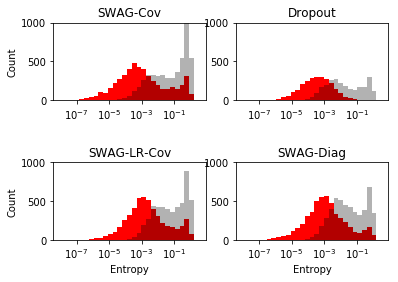

In [9]:
plt.close()
plt.figure(figsize=(12, 16))
f, axarr = plt.subplots(2, 2)
#f.xscale('log')
plt.title('Entropy Distributions')
#plot_entropy(axarr[0,0], laplace_inclass['entropies'], laplace_outclass['entropies'], 'Laplace')
plot_entropy(axarr[0,0], swagfr_cov_inclass['entropies'], swagfr_cov_outclass['entropies'], 'SWAG-Cov')
#plot_entropy(axarr[0,1], swa_inclass['entropies'], swa_outclass['entropies'], 'SWA')
plot_entropy(axarr[0,1], dropout_inclass['entropies'], dropout_outclass['entropies'], 'Dropout')
plot_entropy(axarr[1,0], swag_cov_inclass['entropies'], swag_cov_outclass['entropies'], 'SWAG-LR-Cov')
plot_entropy(axarr[1,1], swag_nocov_inclass['entropies'], swag_nocov_outclass['entropies'], 'SWAG-Diag')
axarr[0,0].set(ylabel='Count')
axarr[1,0].set(ylabel='Count', xlabel='Entropy')
axarr[1,1].set(xlabel='Entropy')

f.subplots_adjust(hspace=0.8)
#plt.show()
#plt.savefig('../plots/cifar10_entropy_dists-1214.pdf')

Text(0,0.5,'SWAG-Laplace')

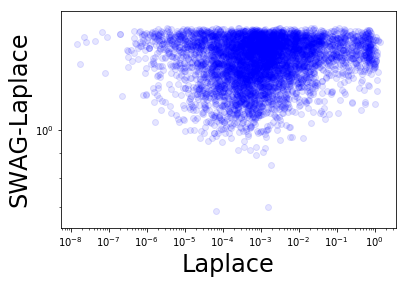

In [8]:
plt.xscale('log')
plt.yscale('log')
plt.scatter(laplace_inclass['entropies'], swag_laplace_inclass['entropies'], c='blue', alpha = 0.1)
#plt.plot(np.arange(1e-7,1.01,.01), np.arange(1e-7,1.01,.01), c='black')
plt.xlabel('Laplace', fontsize=24)
plt.ylabel('SWAG-Laplace', fontsize=24)


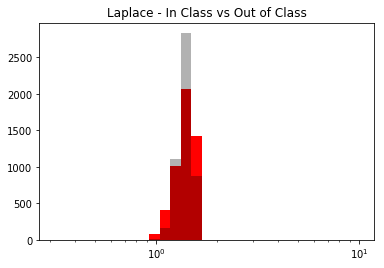

In [9]:
plt.title('Laplace - In Class vs Out of Class', fontsize=12)
plt.xscale('log')
bins = 10 ** np.linspace(-0.5, 1, 30)
plt.hist(swag_laplace_inclass['entropies'], bins=bins, color='red')
plt.hist(swag_laplace_outclass['entropies'], bins=bins, color='black', alpha=0.3)
plt.show()

In [10]:
print( (laplace_inclass['targets'] == swa_inclass['targets']).sum(),
        (swag_cov_inclass['targets'] == swa_inclass['targets']).sum(),
        (swag_nocov_inclass['targets'] == swa_inclass['targets']).sum() )
#labels = np.concatenate((swa_inclass['targets'], np.ones(5000) * -1))
in_out_labels = np.concatenate((np.zeros(5000), np.ones(5000)))

5000 5000 5000


### Accuracy by Threshold

Here, we examine the accuracy by entropy threshold and ultimately compute the AUC.


In [31]:
from sklearn import metrics
#from statsmodels.distributions.empirical_distribution import ECDF

def compute_auc_by_entropy_thresh(threshold, entropy, labels=in_out_labels):
    preds = entropy > threshold
    #entropy_quantiles = ECDF(entropy).y[1:]
    #print(len(entropy_quantiles), len(labels))
    fpr, tpr, thresholds = metrics.roc_curve(labels, preds, pos_label=1)
    #print(fpr[1], tpr[1])
    return metrics.roc_auc_score(y_true=labels, y_score=preds)

def compute_auc_by_entropy(entropy, labels=in_out_labels):
    #all_thresholds = np.unique(entropy)
    all_thresholds = np.percentile(entropy, np.arange(100))
    auc_scores = [compute_auc_by_entropy_thresh(t, entropy) for t in all_thresholds]
    return all_thresholds, auc_scores

In [32]:
laplace_entropy = np.concatenate((laplace_inclass['entropies'], laplace_outclass['entropies']))
slaplace_entropy = np.concatenate((swag_laplace_inclass['entropies'], swag_laplace_outclass['entropies']))
swa_entropy = np.concatenate((swa_inclass['entropies'], swa_outclass['entropies']))
swag_cov_entropy = np.concatenate((swag_cov_inclass['entropies'], swag_cov_outclass['entropies']))
swag_nocov_entropy = np.concatenate((swag_nocov_inclass['entropies'], swag_nocov_outclass['entropies']))

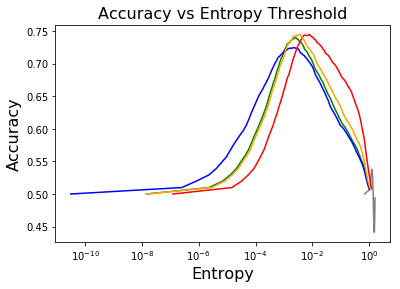

In [35]:
plt.xscale('log')

x, y = compute_auc_by_entropy(laplace_entropy)
plt.plot(x,y, c='green')
x, y = compute_auc_by_entropy(slaplace_entropy)
plt.plot(x,y, c='grey')
x, y = compute_auc_by_entropy(swa_entropy)
plt.plot(x,y, c='blue')
x, y = compute_auc_by_entropy(swag_cov_entropy)
plt.plot(x,y, c='red')
x, y = compute_auc_by_entropy(swag_nocov_entropy)
plt.plot(x,y, c='orange')
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Entropy', fontsize=16)
plt.title('Accuracy vs Entropy Threshold', fontsize=16)
#plt.show()
plt.savefig('../plots/cifar10_auc_entropy.eps')

NameError: name 'ECDF' is not defined

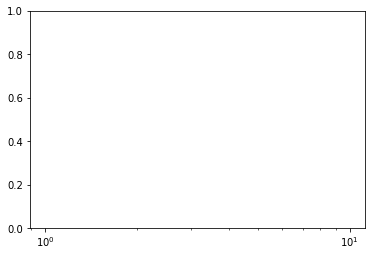

In [34]:
swa_entropy = np.concatenate((swa_inclass['entropies'], swa_outclass['entropies']))
colorvec = ['blue' if l==1 else 'green' for l in in_out_labels]
plt.xscale('log')
#plt.scatter(ECDF(swa_entropy).x, ECDF(swa_entropy).y, color=colorvec, alpha = 0.01)
#plt.xlim((1e-3, 1e-2))
in_ecdf = ECDF(swa_inclass['entropies'])
out_ecdf = ECDF(swa_outclass['entropies'])
plt.plot(in_ecdf.x, in_ecdf.y)
plt.plot(out_ecdf.x, out_ecdf.y)

#### AUC Curves

Here are the AUC curves for the methods. As expected, they all align closely except for slaplace.

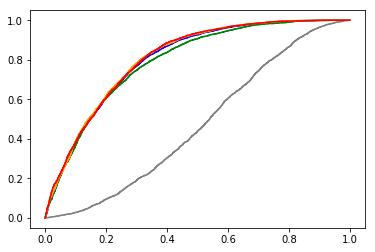

In [30]:
fpr, tpr, thresholds = metrics.roc_curve(in_out_labels, laplace_entropy/max(laplace_entropy) - min(laplace_entropy), pos_label=1)
plt.plot(fpr, tpr, color='blue')
fpr, tpr, thresholds = metrics.roc_curve(in_out_labels, slaplace_entropy, pos_label=1)
plt.plot(fpr, tpr, color='grey')
fpr, tpr, thresholds = metrics.roc_curve(in_out_labels, swa_entropy, pos_label=1)
plt.plot(fpr, tpr, color='green')
fpr, tpr, thresholds = metrics.roc_curve(in_out_labels, swag_nocov_entropy, pos_label=1)
plt.plot(fpr, tpr, color='orange')
fpr, tpr, thresholds = metrics.roc_curve(in_out_labels, swag_cov_entropy, pos_label=1)
plt.plot(fpr, tpr, color='red')

#### AUC for Entropy 

Here is the AUC for entropy. 

In [29]:
print(metrics.roc_auc_score(in_out_labels, laplace_entropy))
print(metrics.roc_auc_score(in_out_labels, swag_cov_entropy))
print(metrics.roc_auc_score(in_out_labels, swag_nocov_entropy))
print(metrics.roc_auc_score(in_out_labels, swa_entropy))
print(metrics.roc_auc_score(in_out_labels, slaplace_entropy))

0.80406244
0.8084476399999999
0.80859608
0.7926174799999999
0.4722129200000001


## Calibration Plots on CIFAR 100

These are the calibration plots (modifications of the plots in Figure 4 of "On Calibration of Modern Neural Networks," Guo et al, https://arxiv.org/pdf/1706.04599.pdf . 

In [12]:
def compute_accuracy_by_entropy(entropy, preds, labels, bins=None):
    #def compute_acc_by_entropy_thresh(threshold, entropy, preds, labels):
    #    #
    #all_thresholds = np.unique(entropy)
    if bins is None:
        bins = np.percentile(entropy, np.arange(100))
    digitized = np.digitize(entropy, bins)
    accuracy = [np.sum(preds[digitized==i]==labels[digitized==i])/np.sum(digitized==i) for i in range(1, len(bins))]
    return accuracy, bins

In [10]:
laplace_inclass = np.load('/home/wesley/Desktop/nfs01_tesla/swa_uncertainties/exps/vgg16_cifar100_0620_1/ent_laplace.npz')

swa_inclass = np.load('/home/wesley/Desktop/nfs01_tesla/swa_uncertainties/exps/vgg16_cifar100_0620_1/ent_swa.pt.npz')

swag_cov_inclass = np.load('/home/wesley/Desktop/nfs01_tesla/swa_uncertainties/exps/vgg16_cifar100_0620_1/ent_swag_cov.pt.npz')

swag_nocov_inclass = np.load('/home/wesley/Desktop/nfs01_tesla/swa_uncertainties/exps/vgg16_cifar100_0620_1/ent_swag_nocov.pt.npz')

dropout_inclass = np.load('../exps/fr_uncertainties/ent_dropout_c100.pt.npz')

swagfr_cov_inclass = np.load('../exps/fr_uncertainties/ent_swag_300_1.npz')

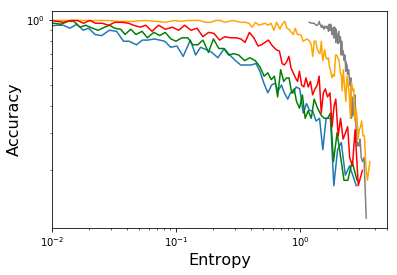

In [9]:
plt.xscale('log')
plt.yscale('log')
plt.xlim((0.01, 5))
acc, bins = compute_accuracy_by_entropy(swa_inclass['entropies'], np.argmax(swa_inclass['predictions'],1), swa_inclass['targets'])
plt.plot(bins[1:], acc)
acc, bins = compute_accuracy_by_entropy(laplace_inclass['entropies'], np.argmax(laplace_inclass['predictions'],1), swa_inclass['targets'])
plt.plot(bins[1:], acc, c='green')
acc, bins = compute_accuracy_by_entropy(swag_laplace_inclass['entropies'], np.argmax(swag_laplace_inclass['predictions'],1), swa_inclass['targets'])
plt.plot(bins[1:], acc, c='grey')
acc, bins = compute_accuracy_by_entropy(swag_cov_inclass['entropies'], np.argmax(swag_cov_inclass['predictions'],1), swa_inclass['targets'])
plt.plot(bins[1:], acc, c='orange')
acc, bins = compute_accuracy_by_entropy(swag_nocov_inclass['entropies'], np.argmax(swag_nocov_inclass['predictions'],1), swa_inclass['targets'])
plt.plot(bins[1:], acc, c='red')
plt.xlabel('Entropy', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
#plt.show()
plt.savefig('../plots/cifar100_entropy_accuracy.eps')

/home/wesley/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


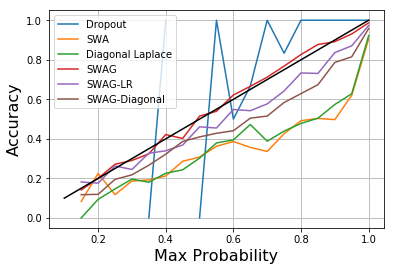

In [16]:
#plt.xscale('log')
acc, bins = compute_accuracy_by_entropy(np.max(dropout_inclass['predictions'],1), 
                                        np.argmax(dropout_inclass['predictions'],1), 
                                        dropout_inclass['targets'], 
                                       bins = np.arange(0.1, 1.05, 0.05)
                                       )
plt.plot(bins[1:], acc, label='Dropout')
acc, bins = compute_accuracy_by_entropy(np.max(swa_inclass['predictions'],1), 
                                        np.argmax(swa_inclass['predictions'],1), 
                                        swa_inclass['targets'], bins = np.arange(0.1, 1.05, 0.05))
plt.plot(bins[1:], acc, label='SWA')
acc, bins = compute_accuracy_by_entropy(np.max(laplace_inclass['predictions'],1), 
                                        np.argmax(laplace_inclass['predictions'],1), 
                                        swa_inclass['targets'],
                                       bins = np.arange(0.1, 1.05, 0.05))
plt.plot(bins[1:], acc, label='Diagonal Laplace')
acc, bins = compute_accuracy_by_entropy(np.max(swagfr_cov_inclass['predictions'],1), 
                                        np.argmax(swagfr_cov_inclass['predictions'],1), 
                                        swagfr_cov_inclass['targets'],
                                       bins = np.arange(0.1, 1.05, 0.05))
plt.plot(bins[1:], acc, label='SWAG')
acc, bins = compute_accuracy_by_entropy(np.max(swag_cov_inclass['predictions'],1), 
                                        np.argmax(swag_cov_inclass['predictions'],1), 
                                        swa_inclass['targets'], 
                                       bins = np.arange(0.1, 1.05, 0.05)
                                       )
plt.plot(bins[1:], acc, label='SWAG-LR')
acc, bins = compute_accuracy_by_entropy(np.max(swag_nocov_inclass['predictions'],1), 
                                        np.argmax(swag_nocov_inclass['predictions'],1), 
                                        swa_inclass['targets'],
                                       bins = np.arange(0.1, 1.05, 0.05))
plt.plot(bins[1:], acc, label='SWAG-Diagonal')

plt.plot(np.arange(0.1,1.01,.01), np.arange(0.1,1.01,.01), c='black')

plt.xlabel('Max Probability', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 16)
plt.grid()
plt.legend()
#plt.savefig('../plots/cifar100_calibration_1219.eps')

Text(0,0.5,'Count')

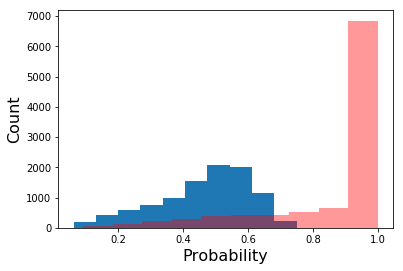

In [12]:
plt.hist(np.max(swag_laplace_inclass['predictions'],1))
plt.hist(np.max(laplace_inclass['predictions'],1),color='red',alpha=0.4)
plt.xlabel('Probability', fontsize=16)
plt.ylabel('Count', fontsize=16)

### Expected Calibration Error

Here I use a modified version of https://github.com/mfinzi/pristine-ml/blob/66bcfd193ea7d8e349634f554e80c6909b8e1b5c/oil/calibration.py. (Thanks Marc!)


In [8]:
def ece_loss(confidences, predictions, labels, bins):
    bin_lowers = bins[:-1]
    bin_uppers = bins[1:]
    
    accuracies = predictions > labels

    #ece = Variable(torch.zeros(1)).type_as(confidences)
    ece = 0.0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Calculated |confidence - accuracy| in each bin
        in_bin = (confidences > bin_lower) * (confidences < bin_upper)
        prop_in_bin = in_bin.mean()
        if prop_in_bin > 0:
            accuracy_in_bin = accuracies[in_bin].mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin- accuracy_in_bin) * prop_in_bin

    return ece

In [12]:
swa_ece = ece_loss(np.max(swa_inclass['predictions'],1), 
                                        np.argmax(swa_inclass['predictions'],1), 
                                        swa_inclass['targets'], bins = np.arange(0.1, 1.05, 0.05))

laplace_ece = ece_loss(np.max(laplace_inclass['predictions'],1), 
                                        np.argmax(laplace_inclass['predictions'],1), 
                                        swa_inclass['targets'],
                                       bins = np.arange(0.1, 1.05, 0.05))

swagfr_cov_ece = ece_loss(np.max(swagfr_cov_inclass['predictions'],1), 
                                        np.argmax(swag_laplace_inclass['predictions'],1), 
                                        swag_laplace_inclass['targets'],
                                       bins = np.arange(0.1, 1.05, 0.05))

swag_cov_ece = ece_loss(np.max(swag_cov_inclass['predictions'],1), 
                                        np.argmax(swag_cov_inclass['predictions'],1), 
                                        swa_inclass['targets'], 
                                       bins = np.arange(0.1, 1.05, 0.05))

swag_nocov_ece = ece_loss(np.max(swag_nocov_inclass['predictions'],1), 
                                        np.argmax(swag_nocov_inclass['predictions'],1), 
                                        swa_inclass['targets'],
                                       bins = np.arange(0.1, 1.05, 0.05))

In [13]:
print(laplace_ece)
print(swa_ece)
print(swagfr_cov_ece)
print(swag_cov_ece)
print(swag_nocov_ece)

0.7604077694852638
0.764981419917196
0.6317068380278619
0.670930763719932
0.7092824569839505


In [18]:
dacc, dbins = compute_accuracy_by_entropy(np.max(dropout_inclass['predictions'],1), 
                                        np.argmax(dropout_inclass['predictions'],1), 
                                        dropout_inclass['targets'], 
                                       bins = np.arange(0.1, 1.05, 0.05))

/home/wesley/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


In [21]:
dacc

[nan,
 nan,
 nan,
 nan,
 0.0,
 1.0,
 nan,
 0.0,
 1.0,
 0.5,
 0.6666666666666666,
 1.0,
 0.8333333333333334,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

Text(0,0.5,'Count')

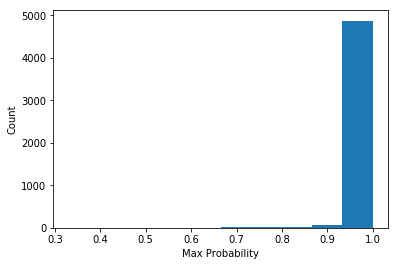

In [26]:
plt.hist(np.max(dropout_inclass['predictions'],1))
plt.xlabel('Max Probability')
plt.ylabel('Count')